In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from pandas_datareader._utils import RemoteDataError

np.random.seed(777)

In [11]:
def DDTW(Q, C):
    """
    Args:
        Q (np.array or list): 一つ目の波形
        C (np.array or list): 二つ目の波形

    Returns:
        γ_mat (np.array): DDTWを計算するための行列
        arrows (np.array): 各時点で←・↙︎・↓のどのマスが最小だったかを示す記号を保存する行列
        ddtw (float): DDTW
    """
    Q, C = np.array(Q), np.array(C)
    assert Q.shape[0] > 3, "一つ目の波形のフォーマットがおかしいです。"
    assert C.shape[0] > 3, "二つ目の波形のフォーマットがおかしいです。"

    # 3.1 Algorithm details の式
    def _Dq(q):
        return ((q[1] - q[0]) + (q[2] - q[0]) / 2) / 2

    # 二つの時点間の距離
    def _γ(x, y):
        return abs(_Dq(x) - _Dq(y))

    # 各変数
    n, m = Q.shape[0] - 2, C.shape[0] - 2
    γ_mat = np.zeros((n, m))
    arrows = np.array(np.zeros((n, m)), dtype=str)  # 可視化用の行列でDDTWの値とは無関係

    # 一番左下のスタート地点
    γ_mat[0, 0] = _γ(Q[0:3], C[0:3])

    # 一列目を計算
    for i in range(1, n):
        γ_mat[i, 0] = γ_mat[i - 1, 0] + _γ(Q[i - 1 : i + 2], C[0:3])
        arrows[i, 0] = "↓"

    # 一行目を計算
    for j in range(1, m):
        γ_mat[0, j] = γ_mat[0, j - 1] + _γ(Q[0:3], C[j - 1 : j + 2])
        arrows[0, j] = "←"

    # 残りのマスを計算
    for i in range(1, n):
        for j in range(1, m):
            # DDTWを求めるためのマトリクスを埋める
            d_ij = _γ(Q[i - 1 : i + 2], C[j - 1 : j + 2])
            γ_mat[i, j] = d_ij + np.min(
                [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
            )

            # 矢印を書くための行列(DDTWの値とは関係無い処理)
            if (
                square_index := np.argmin(
                    [γ_mat[i - 1, j - 1], γ_mat[i - 1, j], γ_mat[i, j - 1]]
                )
            ) == 0:
                arrows[i, j] = "↙︎"
            elif square_index == 1:
                arrows[i, j] = "↓"
            elif square_index == 2:
                arrows[i, j] = "←"

    return γ_mat, arrows, γ_mat[n - 1, m - 1]

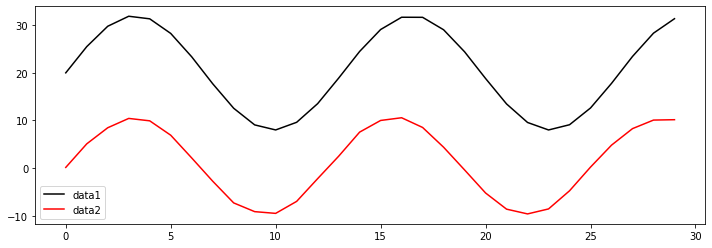

In [12]:
data1 = np.array([12.0 * np.sin(i / 2.1) + 20 for i in range(30)])
data2 = np.array([10.0 * np.sin(i / 2.0) + np.random.rand() for i in range(30)])

plt.figure(figsize=(12, 4))

# 波形をプロット
plt.plot(data1, label="data1", color="k")
plt.plot(data2, label="data2", color="r")
plt.legend()
plt.show()

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

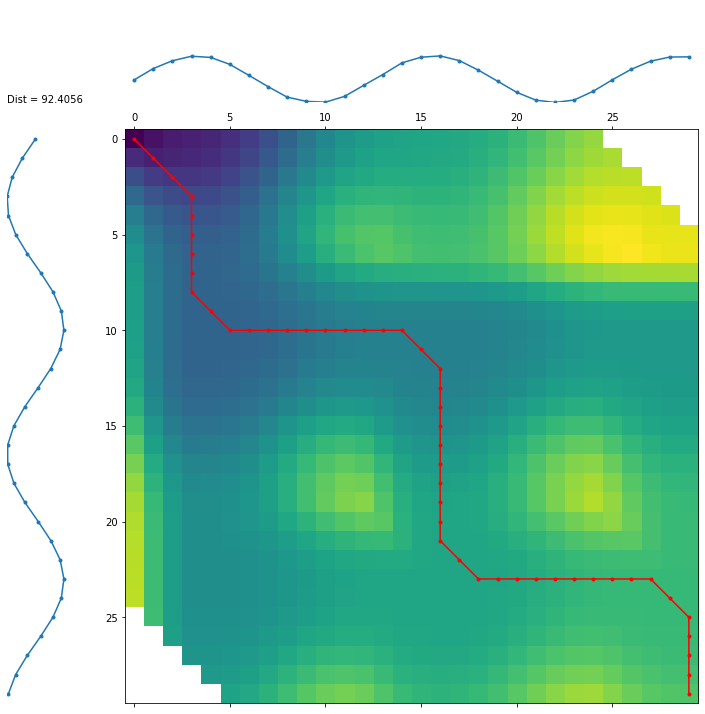

In [15]:
d, paths = dtw.warping_paths(data1, data2, window=25,)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(data1, data2, paths, best_path)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


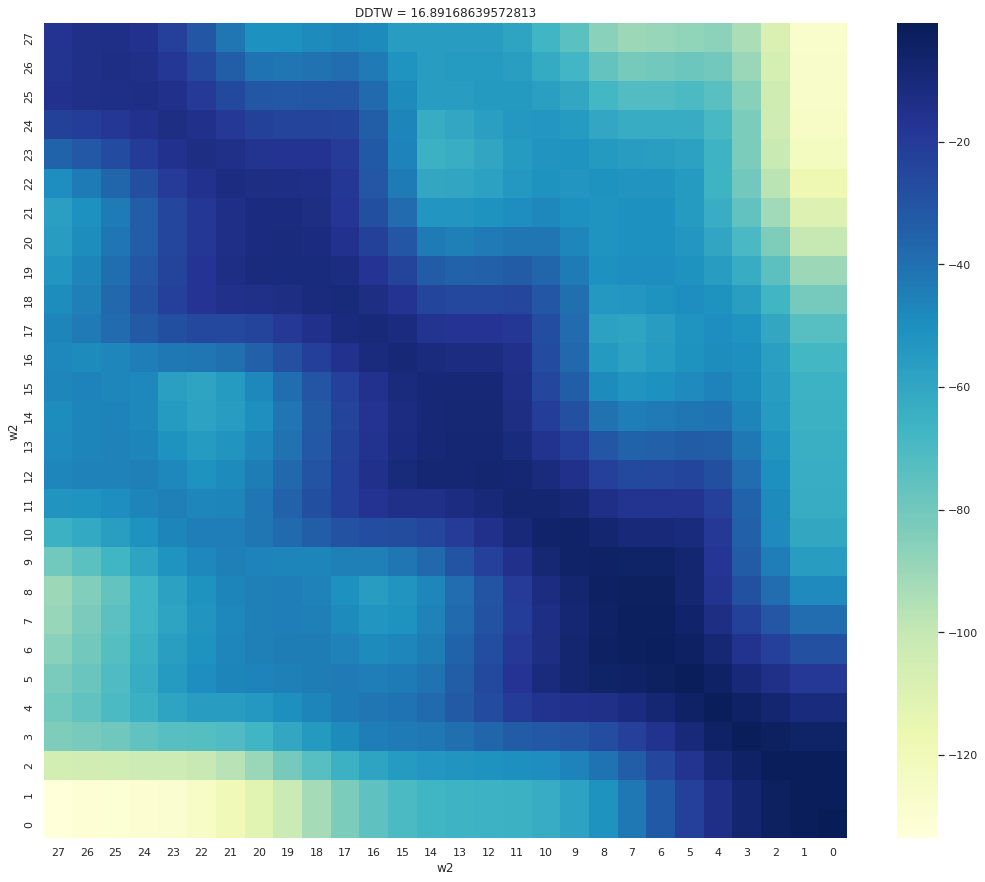

In [16]:
γ_mat, arrows, ddtw = DDTW(np.array(data1), np.array(data2))

sns.set(rc={"figure.figsize": (18, 15)})
sns.set(font="IPAexGothic")
ax = sns.heatmap(-1 * γ_mat, cmap="YlGnBu")
ax.set_title(f"DDTW = {ddtw}")
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel("w2")
ax.set_ylabel("w2")
plt.show()